# Cars Brand Image Classification using CNN

1. [Import libraries](#a0)
2. [Loading data](#a1)
3. [Data mining](#a3)
4. [Data augmentation](#a4)
5. [Model construction](#a5)
6. [Transfer learning - VGG16 model](#a6)
7. [Transfer learning - VGG16 model - unfreezing the last few layers](#a7)
8. [Model evaluation on the test set](#a8)
9. [Display prediction errors](#a9)

## <a name='a0'></a> Import libraries

In [1]:
import os
import zipfile
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import RMSprop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

2023-10-30 13:12:31.051640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 13:12:31.735289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## <a name='a1'></a> Loading data

In [2]:
!rm -Rf data

Unpacking files from the archive

In [3]:
with zipfile.ZipFile("archive.zip","r") as zip_ref:
    zip_ref.extractall("data")

Creating directories for training and test files

In [5]:
location = 'data'
directories = ['images', 'images/train', 'images/test']
for directory in directories:
    os.mkdir(os.path.join(location, directory))

Creating 20 classes of car brands and dividing the files into 80% training and 20% testing

In [6]:
path = 'data/imgs_zip/imgs/'
for class_ in os.listdir(path)[:20]:
    #print(str(class_))
    os.mkdir('data/images/train/'+class_)
    os.mkdir('data/images/test/'+class_)
    
    data = os.listdir(path+class_)
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)])):
        shutil.copy(img, 'data/images/train/'+class_)
        
    for img in itertools.islice(glob.iglob(os.path.join(path+class_, '*jpg')), 
                                 len(data[:round(len(data)*0.8)]), len(data)):
        shutil.copy(img, 'data/images/test/'+class_)

## <a name='a3'></a> Data mining

In [7]:
os.listdir('data/images/train')

['Audi',
 'Hudson',
 'Mercedes-Benz',
 'Lincoln',
 'Bugatti',
 'Genesis',
 'Hyundai',
 'Buick',
 'Volkswagen',
 'Jaguar',
 'Jeep',
 'Bentley',
 'Cadillac',
 'Honda',
 'Subaru',
 'Acura',
 'Porsche',
 'Dodge',
 'Aston Martin',
 'Infiniti']

In [8]:
os.listdir('data/images/test')

['Audi',
 'Hudson',
 'Mercedes-Benz',
 'Lincoln',
 'Bugatti',
 'Genesis',
 'Hyundai',
 'Buick',
 'Volkswagen',
 'Jaguar',
 'Jeep',
 'Bentley',
 'Cadillac',
 'Honda',
 'Subaru',
 'Acura',
 'Porsche',
 'Dodge',
 'Aston Martin',
 'Infiniti']

In [9]:
os.listdir('data/images/train/Audi')

['Audi_081.jpg',
 'Audi_052.jpg',
 'Audi_072.jpg',
 'Audi_029.jpg',
 'Audi_025.jpg',
 'Audi_028.jpg',
 'Audi_001.jpg',
 'Audi_067.jpg',
 'Audi_047.jpg',
 'Audi_082.jpg',
 'Audi_074.jpg',
 'Audi_063.jpg',
 'Audi_043.jpg',
 'Audi_065.jpg',
 'Audi_078.jpg',
 'Audi_064.jpg',
 'Audi_079.jpg',
 'Audi_027.jpg',
 'Audi_022.jpg',
 'Audi_020.jpg',
 'Audi_039.jpg',
 'Audi_049.jpg',
 'Audi_011.jpg',
 'Audi_062.jpg',
 'Audi_019.jpg',
 'Audi_012.jpg',
 'Audi_016.jpg',
 'Audi_018.jpg',
 'Audi_056.jpg',
 'Audi_032.jpg',
 'Audi_003.jpg',
 'Audi_040.jpg',
 'Audi_026.jpg',
 'Audi_031.jpg',
 'Audi_075.jpg',
 'Audi_066.jpg',
 'Audi_077.jpg',
 'Audi_045.jpg',
 'Audi_024.jpg',
 'Audi_048.jpg',
 'Audi_044.jpg',
 'Audi_036.jpg',
 'Audi_071.jpg',
 'Audi_023.jpg',
 'Audi_070.jpg',
 'Audi_010.jpg',
 'Audi_033.jpg',
 'Audi_051.jpg',
 'Audi_009.jpg',
 'Audi_042.jpg',
 'Audi_053.jpg',
 'Audi_057.jpg',
 'Audi_060.jpg',
 'Audi_069.jpg',
 'Audi_017.jpg',
 'Audi_037.jpg',
 'Audi_008.jpg',
 'Audi_050.jpg',
 'Audi_058.jpg

(-0.5, 299.5, 167.5, -0.5)

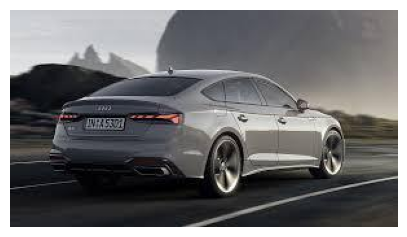

In [10]:
img = image.load_img('data/images/train/Audi/Audi_000.jpg')

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

## <a name='a4'></a> Data augmentation

In [11]:
train_datagen = ImageDataGenerator(
     rotation_range=40, # angle range by which the images will randomly rotate
     rescale=1./255.,
     width_shift_range=0.2, # vertical image transformations
     height_shift_range=0.2, # horizontal image transformations
     shear_range=0.2, # random image cropping range
     zoom_range=0.2, # random image zoom range
     horizontal_flip=True, # random flip of half the image in the horizontal plane
     fill_mode='nearest' # strategy for filling newly created pixels that may result from transformations
)

train_gen = train_datagen.flow_from_directory('data/images/train',
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical')
test_gen = ImageDataGenerator().flow_from_directory('data/images/test',
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 1464 images belonging to 20 classes.
Found 366 images belonging to 20 classes.


Sample images obtained using the technique data augmentation

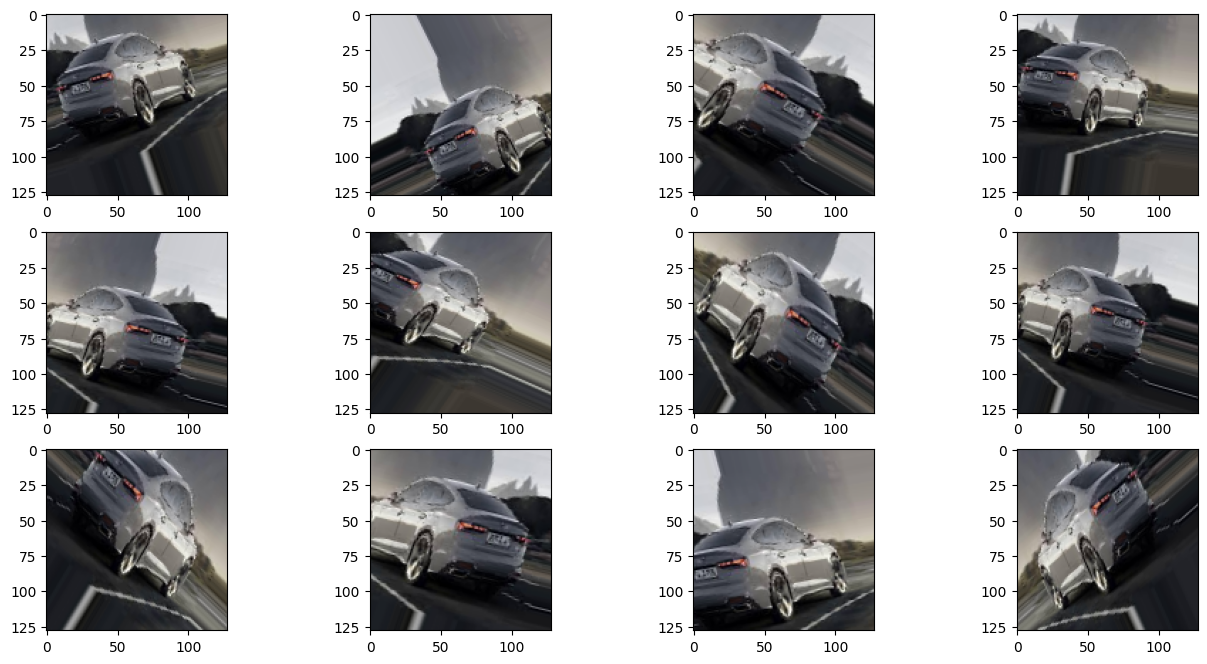

In [12]:
img = image.load_img('data/images/train/Audi/Audi_000.jpg',target_size=(128, 128))# plt.imshow(img)
#img = image.load_img(img_path, target_size=(128, 128))

x = image.img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 1
plt.figure(figsize=(16, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(3, 4, i)
    plt.grid(False)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 13 == 0:
        break

##  <a name='a5'></a> Model construction

### CNN

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (128, 128,3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation = "softmax"))
model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

2023-10-30 13:13:39.474345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-30 13:13:39.487133: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
history = model.fit_generator(train_gen, validation_data=test_gen, steps_per_epoch=10, validation_steps=10, epochs=20)

Epoch 1/20


/tmp/ipykernel_157086/459043364.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data=test_gen, steps_per_epoch=10, validation_steps=10, epochs=20)


10/10 [==============================] - 7s 742ms/step - loss: 2.9956 - accuracy: 0.0481 - val_loss: 3.3268 - val_accuracy: 0.0562
Epoch 2/20
10/10 [==============================] - 8s 757ms/step - loss: 2.9924 - accuracy: 0.0531 - val_loss: 3.9096 - val_accuracy: 0.0594
Epoch 3/20
10/10 [==============================] - 7s 740ms/step - loss: 2.9967 - accuracy: 0.0609 - val_loss: 3.6972 - val_accuracy: 0.0531
Epoch 4/20
10/10 [==============================] - 8s 759ms/step - loss: 2.9943 - accuracy: 0.0719 - val_loss: 4.0204 - val_accuracy: 0.0406
Epoch 5/20
10/10 [==============================] - 8s 755ms/step - loss: 2.9952 - accuracy: 0.0531 - val_loss: 4.2687 - val_accuracy: 0.0531
Epoch 6/20
10/10 [==============================] - 7s 746ms/step - loss: 2.9925 - accuracy: 0.0545 - val_loss: 3.5940 - val_accuracy: 0.0437
Epoch 7/20
10/10 [==============================] - 8s 758ms/step - loss: 2.9932 - accuracy: 0.0656 - val_loss: 3.5033 - val_accuracy: 0.0562
Epoch 8/20
10/10 

In [39]:
model.predict(train_gen, test_gen).max()

46/46 [==============================] - 6s 120ms/step


0.32445577

In [17]:
history.history['accuracy']

[0.048076923936605453,
 0.05312500149011612,
 0.06089743599295616,
 0.07187499850988388,
 0.05312500149011612,
 0.05448717996478081,
 0.06562499701976776,
 0.03846153989434242,
 0.07051282376050949,
 0.057692307978868484,
 0.05000000074505806,
 0.05624999850988388,
 0.046875,
 0.05000000074505806,
 0.04062499850988388,
 0.035256411880254745,
 0.03437500074505806,
 0.03750000149011612,
 0.046875,
 0.05000000074505806]

In [18]:
os.mkdir('models')

In [19]:
model.save('models/cnn_model.h5')

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Vgg16

In [41]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [42]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [59]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=20, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 20)                5140      
                                                                 
Total params: 22126932 (84.41 MB)
Trainable params: 11541780 (44.03 MB)
Non-trainable params: 10585152 (40.38 MB)
_________________________________________________________________


In [60]:
# model.fit_generator(train_gen, validation_data=test_gen, steps_per_epoch=10, validation_steps=10, epochs=20)
history = model.fit_generator(generator=train_gen,
                             steps_per_epoch=10,
                             epochs=20,    # 100
                             validation_data=test_gen,
                             validation_steps=10)

Epoch 1/20


/tmp/ipykernel_115892/95786306.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,


10/10 [==============================] - 14s 1s/step - loss: 3.1372 - accuracy: 0.0625 - val_loss: 23.0373 - val_accuracy: 0.0594
Epoch 2/20
10/10 [==============================] - 14s 1s/step - loss: 3.0973 - accuracy: 0.0656 - val_loss: 22.6566 - val_accuracy: 0.0500
Epoch 3/20
10/10 [==============================] - 14s 1s/step - loss: 3.0680 - accuracy: 0.0625 - val_loss: 21.1117 - val_accuracy: 0.0531
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 3.0209 - accuracy: 0.0562 - val_loss: 21.8929 - val_accuracy: 0.0656
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 3.0064 - accuracy: 0.0673 - val_loss: 22.1041 - val_accuracy: 0.0656
Epoch 6/20
10/10 [==============================] - 14s 1s/step - loss: 2.9920 - accuracy: 0.0531 - val_loss: 22.5055 - val_accuracy: 0.0688
Epoch 7/20
10/10 [==============================] - 14s 1s/step - loss: 2.9706 - accuracy: 0.0688 - val_loss: 22.5085 - val_accuracy: 0.0688
Epoch 8/20
10/10 [======

In [62]:
predict = model.predict_generator(test_gen)

/tmp/ipykernel_115892/1713836850.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_gen)


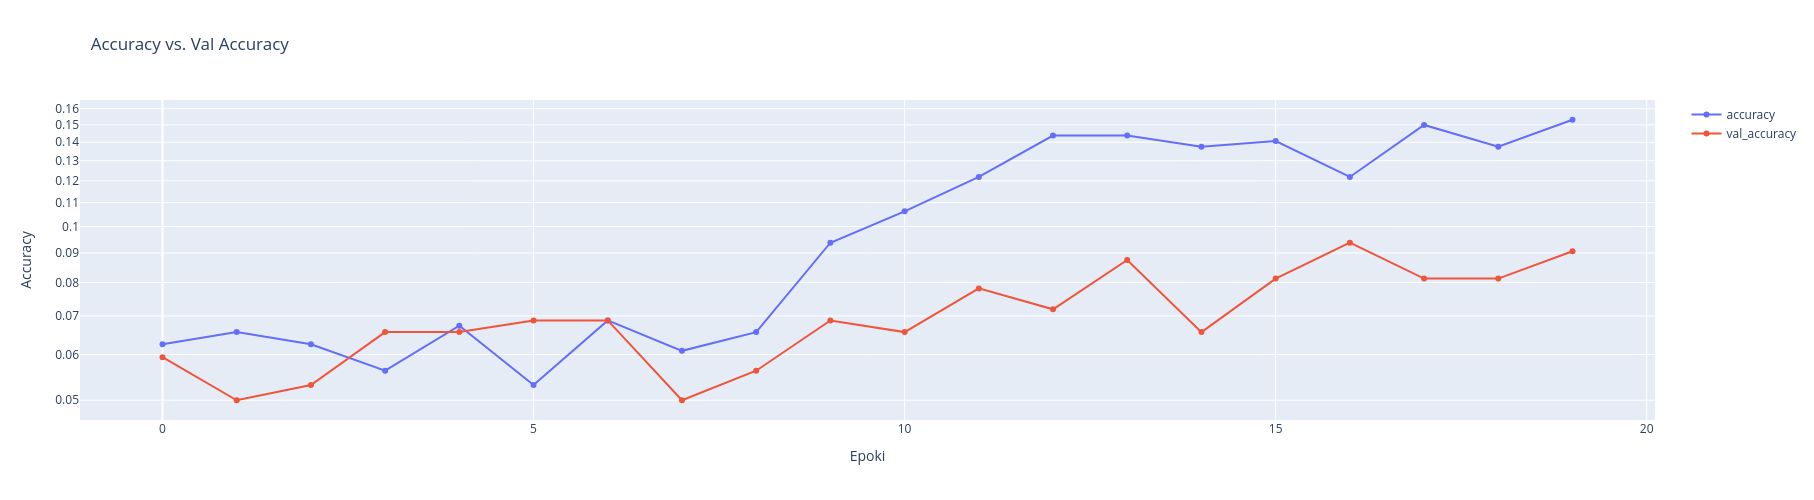

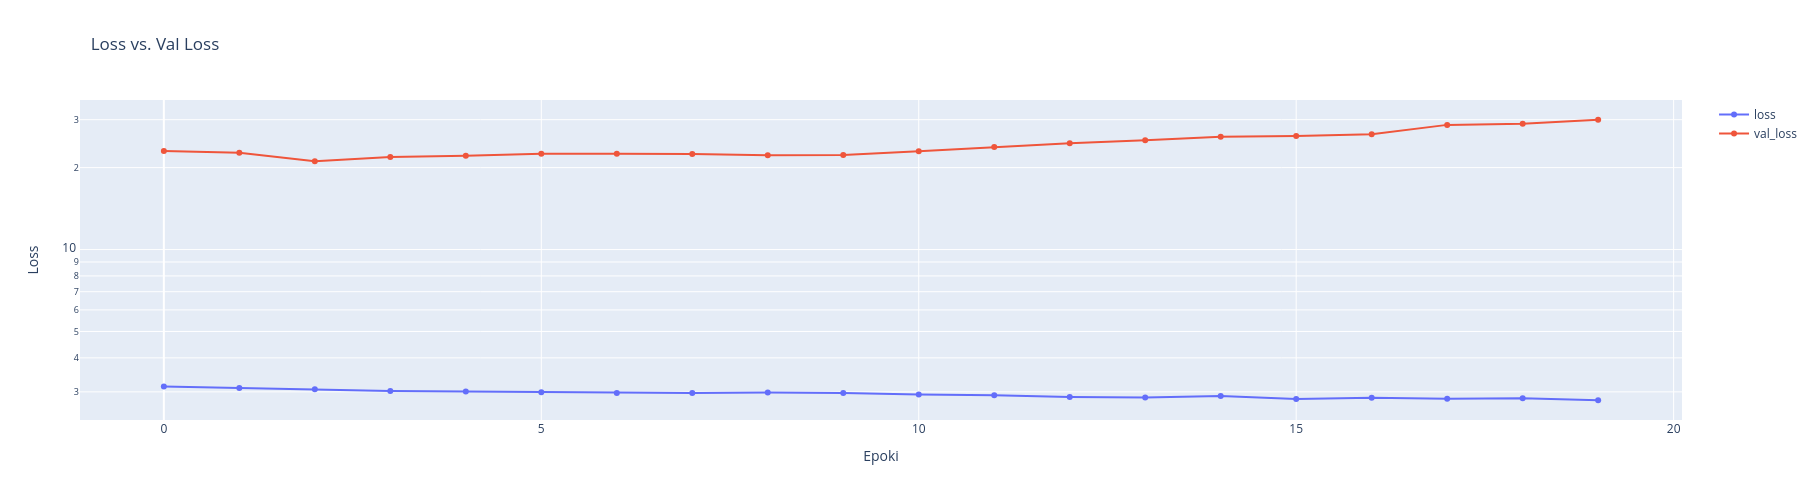

In [63]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [65]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    'data/images/test',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 366 images belonging to 20 classes.


/tmp/ipykernel_115892/3344239233.py:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.04014868, 0.06083423, 0.03090739, ..., 0.04592321, 0.03151596,
        0.04648459],
       [0.04426273, 0.05053959, 0.02971546, ..., 0.06105308, 0.04494086,
        0.05220473],
       [0.03798075, 0.13103828, 0.02042745, ..., 0.03356832, 0.04538763,
        0.04560681],
       ...,
       [0.04849229, 0.03583036, 0.02904469, ..., 0.02685168, 0.04597479,
        0.1557963 ],
       [0.08597785, 0.0372001 , 0.02556827, ..., 0.02237707, 0.05073653,
        0.06828578],
       [0.0322248 , 0.08249538, 0.04742545, ..., 0.06038858, 0.04499963,
        0.0660181 ]], dtype=float32)

In [66]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([ 6, 11,  1,  1, 12, 11,  1, 11, 11,  1, 11, 11,  8,  1,  1, 11, 11,
        0,  0,  5,  1,  8,  1, 10, 13, 11,  3, 12,  1,  6,  0,  5, 12,  0,
        5,  1, 19, 11, 11,  6, 12, 11, 19,  6,  0, 19, 11, 11,  0,  1, 11,
       11, 11,  1,  1, 11, 14,  1, 19,  3, 11, 14, 11, 11, 13,  1,  6,  1,
        1,  3,  0,  6,  1,  1,  1,  1,  1,  5,  7, 19, 11, 19,  3,  7,  6,
        1,  1,  7, 10, 19,  1, 19,  0,  6,  5, 11, 15,  3, 14, 13,  1,  1,
        0, 10, 13, 10, 11,  0,  6,  1,  9,  9,  8,  3,  9,  6, 11, 11, 12,
        1, 14, 13,  1, 15,  6,  5, 11, 14, 14,  0,  0,  1, 19, 19,  0, 11,
       12,  3, 12,  1,  5,  5,  6,  1, 15,  5, 11, 10,  1,  9, 12, 10, 19,
        0,  0,  8, 12, 19, 10,  1, 10,  0, 12, 18,  9,  1, 10,  3, 11, 19,
       11, 10, 15, 13, 11, 11,  9, 19,  9, 12, 10,  9,  9, 10, 10,  0, 10,
       15, 10, 10, 10, 11, 10, 10, 19, 10, 10, 13,  8, 10,  4,  0,  0, 19,
        8, 11,  6,  0, 11, 11, 12,  3,  6, 11,  6, 12, 12,  6, 11,  0,  6,
        0, 11, 11, 13,  1

In [67]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

class
0        6
1       11
2        1
3        1
4       12
..     ...
361      8
362     13
363     19
364     14
365      9

[366 rows x 1 columns]

In [68]:
y_true = test_generator.classes
y_true

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 12, 12

In [69]:
y_pred = predictions['class'].values
y_pred

array([ 6, 11,  1,  1, 12, 11,  1, 11, 11,  1, 11, 11,  8,  1,  1, 11, 11,
        0,  0,  5,  1,  8,  1, 10, 13, 11,  3, 12,  1,  6,  0,  5, 12,  0,
        5,  1, 19, 11, 11,  6, 12, 11, 19,  6,  0, 19, 11, 11,  0,  1, 11,
       11, 11,  1,  1, 11, 14,  1, 19,  3, 11, 14, 11, 11, 13,  1,  6,  1,
        1,  3,  0,  6,  1,  1,  1,  1,  1,  5,  7, 19, 11, 19,  3,  7,  6,
        1,  1,  7, 10, 19,  1, 19,  0,  6,  5, 11, 15,  3, 14, 13,  1,  1,
        0, 10, 13, 10, 11,  0,  6,  1,  9,  9,  8,  3,  9,  6, 11, 11, 12,
        1, 14, 13,  1, 15,  6,  5, 11, 14, 14,  0,  0,  1, 19, 19,  0, 11,
       12,  3, 12,  1,  5,  5,  6,  1, 15,  5, 11, 10,  1,  9, 12, 10, 19,
        0,  0,  8, 12, 19, 10,  1, 10,  0, 12, 18,  9,  1, 10,  3, 11, 19,
       11, 10, 15, 13, 11, 11,  9, 19,  9, 12, 10,  9,  9, 10, 10,  0, 10,
       15, 10, 10, 10, 11, 10, 10, 19, 10, 10, 13,  8, 10,  4,  0,  0, 19,
        8, 11,  6,  0, 11, 11, 12,  3,  6, 11,  6, 12, 12,  6, 11,  0,  6,
        0, 11, 11, 13,  1

In [70]:
test_generator.class_indices

{'Acura': 0,
 'Aston Martin': 1,
 'Audi': 2,
 'Bentley': 3,
 'Bugatti': 4,
 'Buick': 5,
 'Cadillac': 6,
 'Dodge': 7,
 'Genesis': 8,
 'Honda': 9,
 'Hudson': 10,
 'Hyundai': 11,
 'Infiniti': 12,
 'Jaguar': 13,
 'Jeep': 14,
 'Lincoln': 15,
 'Mercedes-Benz': 16,
 'Porsche': 17,
 'Subaru': 18,
 'Volkswagen': 19}

In [71]:
classes = list(test_generator.class_indices.keys())
classes

['Acura',
 'Aston Martin',
 'Audi',
 'Bentley',
 'Bugatti',
 'Buick',
 'Cadillac',
 'Dodge',
 'Genesis',
 'Honda',
 'Hudson',
 'Hyundai',
 'Infiniti',
 'Jaguar',
 'Jeep',
 'Lincoln',
 'Mercedes-Benz',
 'Porsche',
 'Subaru',
 'Volkswagen']

In [72]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 1,  6,  0,  0,  0,  0,  1,  0,  1,  0,  0,  8,  1,  0,  0,  0,
         0,  0,  0,  0],
       [ 3,  4,  0,  1,  0,  3,  1,  0,  1,  0,  1,  1,  2,  1,  0,  0,
         0,  0,  0,  0],
       [ 2,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  8,  1,  0,  0,  0,
         0,  0,  0,  3],
       [ 1,  6,  0,  2,  0,  0,  1,  0,  0,  0,  0,  4,  0,  1,  2,  0,
         0,  0,  0,  1],
       [ 0,  7,  0,  1,  0,  1,  2,  3,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  2],
       [ 3,  3,  0,  1,  0,  1,  1,  0,  0,  0,  2,  2,  0,  2,  1,  1,
         0,  0,  0,  2],
       [ 0,  3,  0,  1,  0,  0,  3,  0,  1,  3,  0,  2,  1,  1,  1,  1,
         0,  0,  0,  0],
       [ 3,  2,  0,  1,  0,  3,  0,  0,  0,  0,  0,  2,  2,  0,  2,  0,
         0,  0,  0,  2],
       [ 3,  3,  0,  0,  0,  1,  1,  0,  1,  1,  4,  1,  2,  0,  0,  1,
         0,  0,  0,  2],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  0,  3,  2,  4,  2,  1,  0,  1,
         0,  0,  1,  2],
       [ 1,  0,  0,  0,  0,  0

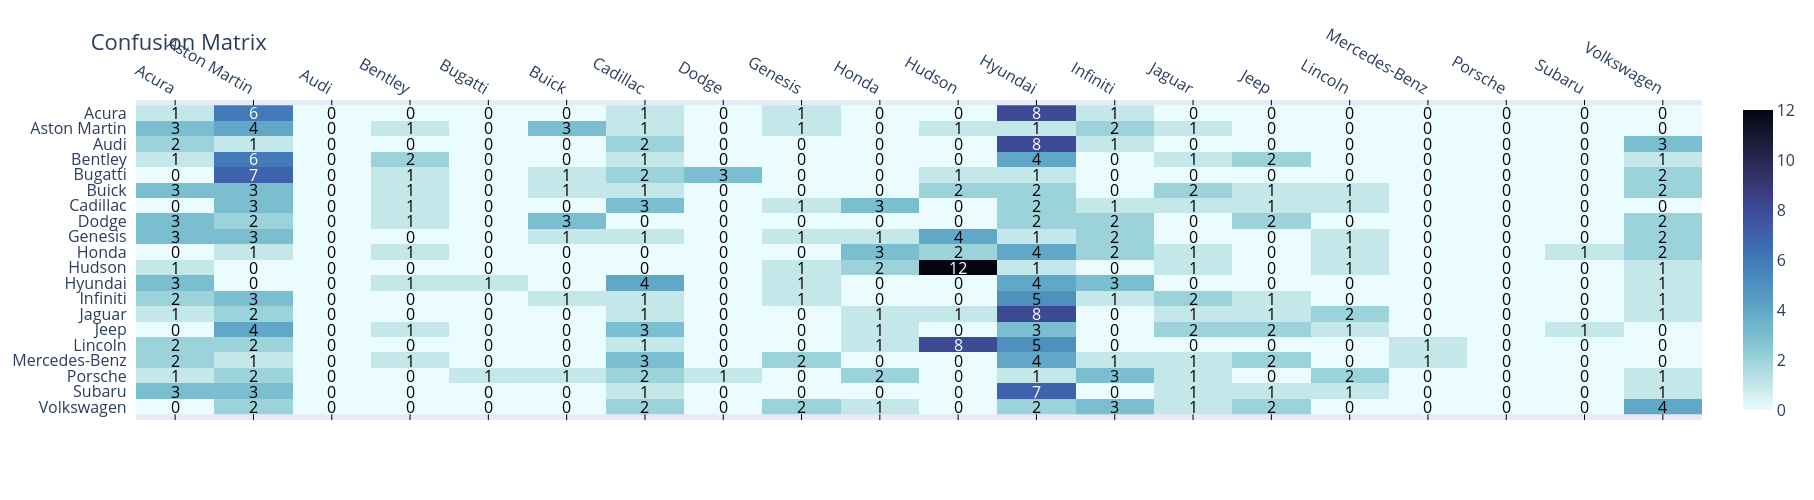

In [73]:
def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [74]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

               precision    recall  f1-score   support

        Acura       0.03      0.06      0.04        18
 Aston Martin       0.07      0.22      0.11        18
         Audi       0.00      0.00      0.00        17
      Bentley       0.18      0.11      0.14        18
      Bugatti       0.00      0.00      0.00        18
        Buick       0.09      0.05      0.07        19
     Cadillac       0.10      0.18      0.13        17
        Dodge       0.00      0.00      0.00        17
      Genesis       0.09      0.05      0.06        20
        Honda       0.20      0.17      0.18        18
       Hudson       0.39      0.60      0.47        20
      Hyundai       0.05      0.22      0.09        18
     Infiniti       0.05      0.06      0.05        18
       Jaguar       0.06      0.05      0.06        19
         Jeep       0.13      0.11      0.12        18
      Lincoln       0.00      0.00      0.00        20
Mercedes-Benz       0.50      0.06      0.10        18
      Por

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/marcin/.virtualenvs/ds2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [75]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
Acura/Acura_005.jpg                 0       6
Acura/Acura_006.jpg                 0      11
Acura/Acura_010.jpg                 0       1
Acura/Acura_015.jpg                 0       1
Acura/Acura_019.jpg                 0      12
...                               ...     ...
Volkswagen/Volkswagen_078.jpg      19       8
Volkswagen/Volkswagen_081.jpg      19      13
Volkswagen/Volkswagen_087.jpg      19      19
Volkswagen/Volkswagen_088.jpg      19      14
Volkswagen/Volkswagen_092.jpg      19       9

[366 rows x 2 columns]

In [76]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  is_incorrect
Acura/Acura_005.jpg                 0       6             1
Acura/Acura_006.jpg                 0      11             1
Acura/Acura_010.jpg                 0       1             1
Acura/Acura_015.jpg                 0       1             1
Acura/Acura_019.jpg                 0      12             1
...                               ...     ...           ...
Volkswagen/Volkswagen_078.jpg      19       8             1
Volkswagen/Volkswagen_081.jpg      19      13             1
Volkswagen/Volkswagen_087.jpg      19      19             0
Volkswagen/Volkswagen_088.jpg      19      14             1
Volkswagen/Volkswagen_092.jpg      19       9             1

[366 rows x 3 columns]

In [77]:
errors[errors['is_incorrect'] == 1].index

Index(['Acura/Acura_005.jpg', 'Acura/Acura_006.jpg', 'Acura/Acura_010.jpg',
       'Acura/Acura_015.jpg', 'Acura/Acura_019.jpg', 'Acura/Acura_024.jpg',
       'Acura/Acura_038.jpg', 'Acura/Acura_044.jpg', 'Acura/Acura_045.jpg',
       'Acura/Acura_046.jpg',
       ...
       'Volkswagen/Volkswagen_061.jpg', 'Volkswagen/Volkswagen_066.jpg',
       'Volkswagen/Volkswagen_070.jpg', 'Volkswagen/Volkswagen_071.jpg',
       'Volkswagen/Volkswagen_072.jpg', 'Volkswagen/Volkswagen_075.jpg',
       'Volkswagen/Volkswagen_078.jpg', 'Volkswagen/Volkswagen_081.jpg',
       'Volkswagen/Volkswagen_088.jpg', 'Volkswagen/Volkswagen_092.jpg'],
      dtype='object', length=326)

(-0.5, 299.5, 167.5, -0.5)

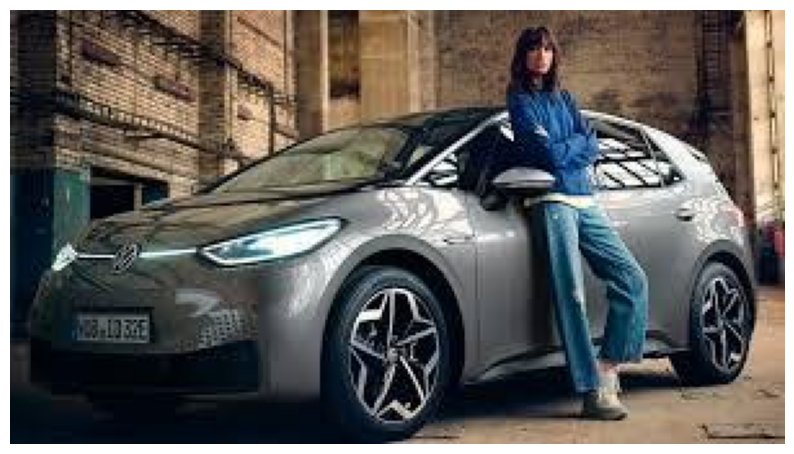

In [83]:
img_path = os.path.join('data/images/test', 'Volkswagen/Volkswagen_092.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)